# Dirty Dataset Detective – Main Challenge (Cycle 1)

##  Objective
Clean and model a corrupted real-world dataset on medical insurance costs.
- Clean the dataset (missing values, inconsistent categories, outliers)
- Perform feature selection
- Build a regression model
- Improve R² score from < 0.6 to > 0.85


Step 1: Load Libraries and Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [5]:
df = pd.read_csv('/content/insurance.csv')
print(df.head())
df.info()
print(df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())
for col in ['sex', 'smoker', 'region']:
    print(f"\nUnique values in {col}: {df[col].unique()}")

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     

Step 2: Data Cleaning

In [7]:
df = df.drop_duplicates()
print("Duplicate Rows after cleaning:", df.duplicated().sum())
for col in ['sex', 'smoker', 'region']:
    print(f"\nUnique values in {col} after cleaning: {df[col].unique()}")
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df
df = cap_outliers(df, 'bmi')
df = cap_outliers(df, 'charges')
print("\nDataset Info after cleaning:")
df.info()
print("\nSummary Statistics after outlier capping:")
print(df[['bmi', 'charges']].describe())

Duplicate Rows after cleaning: 0

Unique values in sex after cleaning: ['female' 'male']

Unique values in smoker after cleaning: ['yes' 'no']

Unique values in region after cleaning: ['southwest' 'southeast' 'northwest' 'northeast']

Dataset Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB

Summary Statistics after outlier capping:
               bmi       charges
count  1337.000000   1337.000000
mean     30.650247  12491.159952
std       6.059655  10165.511950
min      15.960000   1121.873900
25%      26.2

Step 3: Exploratory Data Analysis (EDA)

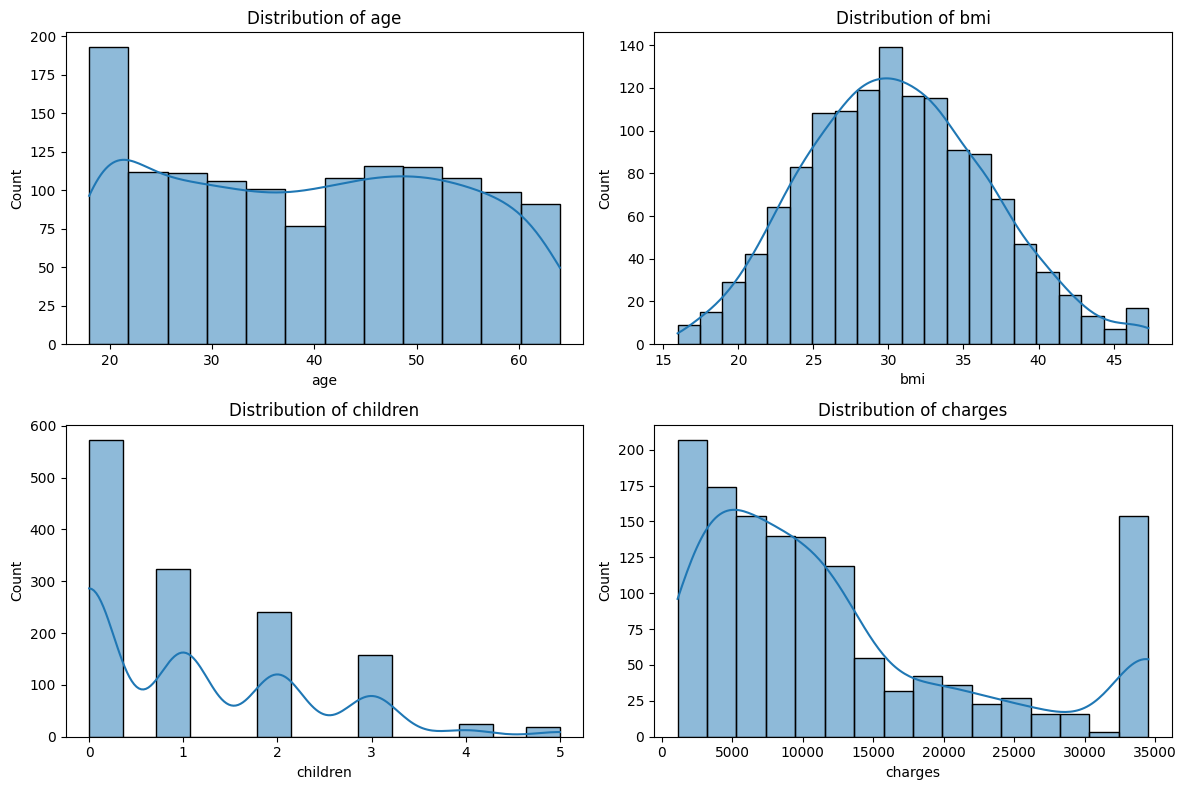

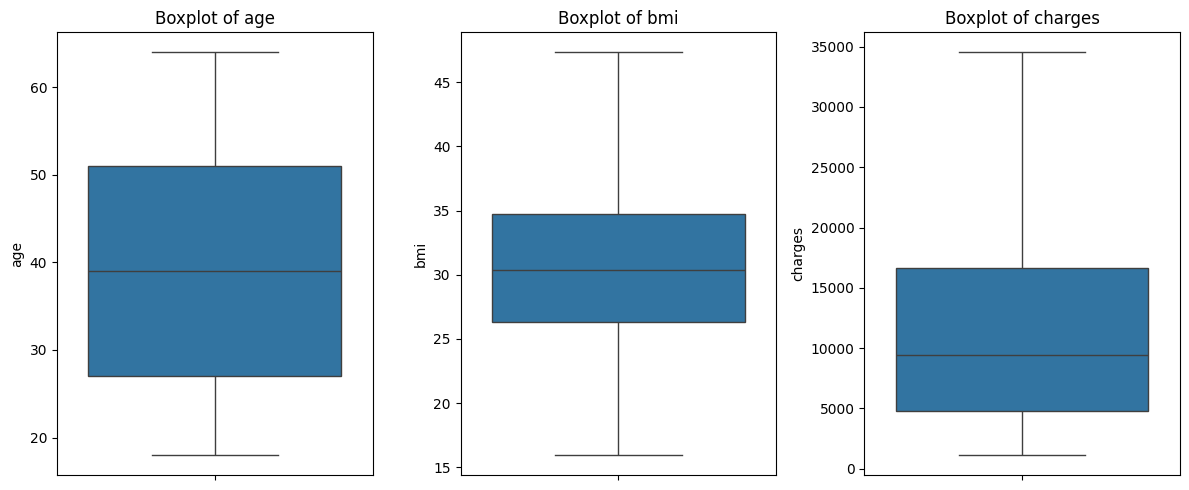

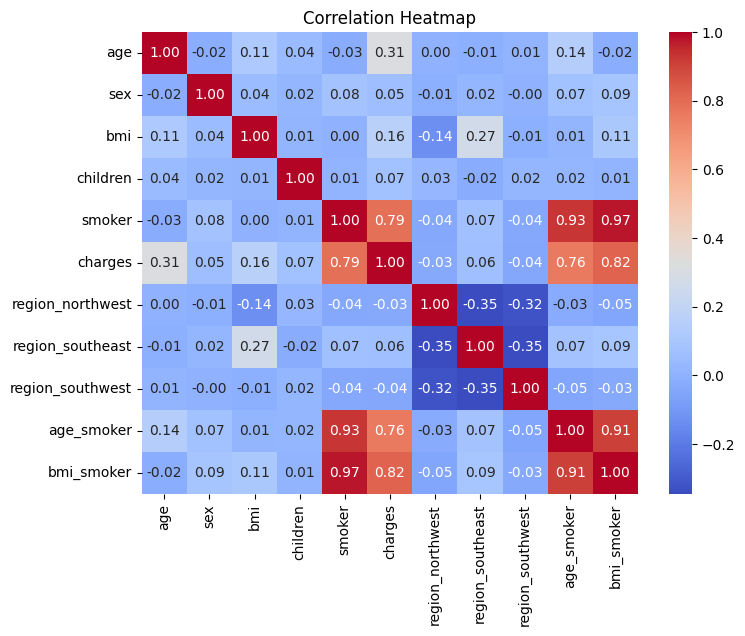

In [24]:
plt.style.use('default')
plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'bmi', 'children', 'charges'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for i, col in enumerate(['age', 'bmi', 'charges'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Step 4: Feature Encoding

In [18]:
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])
if 'region' in df.columns:
    df = pd.get_dummies(df, columns=['region'], drop_first=True)
print("Dataset Head after encoding:")
print(df.head())
print("\nDataset Info after encoding:")
df.info()

Dataset Head after encoding:
   age  sex     bmi  children  smoker      charges  region_northwest  \
0   19    0  27.900         0       1  16884.92400             False   
1   18    1  33.770         1       0   1725.55230             False   
2   28    1  33.000         3       0   4449.46200             False   
3   33    1  22.705         0       0  21984.47061              True   
4   32    1  28.880         0       0   3866.85520              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  

Dataset Info after encoding:
<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   sex               133

Step 5: Feature Engineering and Scaling

In [20]:
df['age_smoker'] = df['age'] * df['smoker']
df['bmi_smoker'] = df['bmi'] * df['smoker']
X = df.drop(columns=['charges'])
y = df['charges']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("Scaled Features Head:")
print(X_scaled.head())
print("\nScaled Features Info:")
X_scaled.info()

Scaled Features Head:
        age       sex       bmi  children    smoker  region_northwest  \
0 -1.440418 -1.009771 -0.454032 -0.909234  1.969660         -0.565546   
1 -1.511647  0.990324  0.515033 -0.079442 -0.507702         -0.565546   
2 -0.799350  0.990324  0.387915  1.580143 -0.507702         -0.565546   
3 -0.443201  0.990324 -1.311662 -0.909234 -0.507702          1.768203   
4 -0.514431  0.990324 -0.292246 -0.909234 -0.507702          1.768203   

   region_southeast  region_southwest  age_smoker  bmi_smoker  
0         -0.611638          1.764609    0.662255    1.700876  
1          1.634955         -0.566698   -0.470625   -0.494977  
2          1.634955         -0.566698   -0.470625   -0.494977  
3         -0.611638         -0.566698   -0.470625   -0.494977  
4         -0.611638         -0.566698   -0.470625   -0.494977  

Scaled Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 10 columns):
 #   Column            No

Step 6: Feature Selection

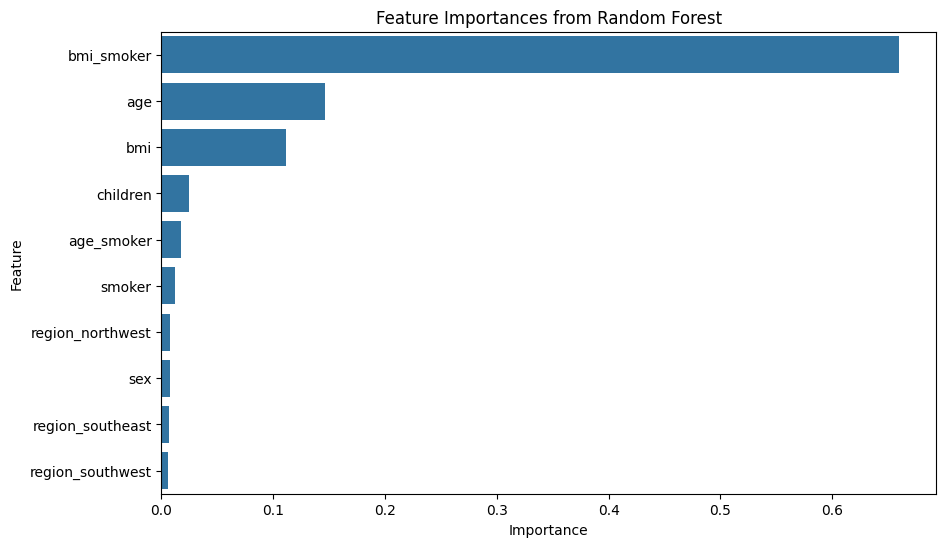

Feature Importances:
            Feature  Importance
9        bmi_smoker    0.660206
0               age    0.146099
2               bmi    0.111298
3          children    0.024641
8        age_smoker    0.017562
4            smoker    0.012595
5  region_northwest    0.008102
1               sex    0.007368
6  region_southeast    0.006649
7  region_southwest    0.005480


In [21]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_scaled, y)
importances = rf.feature_importances_
feature_names = X_scaled.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()
print("Feature Importances:")
print(feature_importance_df)

Step 7: Train and Evaluate Baseline Models

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

#Ridge Regression
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

#Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("🔹 Baseline Model Performance:")
print("\nLinear Regression:")
print(f"MSE: {mse_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")
print("\nRidge Regression:")
print(f"MSE: {mse_ridge:.2f}")
print(f"R² Score: {r2_ridge:.4f}")
print("\nRandom Forest Regressor:")
print(f"MSE: {mse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

🔹 Baseline Model Performance:

Linear Regression:
MSE: 17427054.61
R² Score: 0.8509

Ridge Regression:
MSE: 17309719.34
R² Score: 0.8519

Random Forest Regressor:
MSE: 18827041.58
R² Score: 0.8389


Step 8: Hyperparameter Tuning for Random Forest

In [23]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

y_pred_best_rf = best_rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\n🔹 Tuned Random Forest Regressor:")
print(f"MSE: {mse_best_rf:.2f}")
print(f"R² Score: {r2_best_rf:.4f}")
print("\n🔹 Model Performance Comparison:")
print(f"Linear Regression: MSE = 17427054.61, R² = 0.8509")
print(f"Ridge Regression: MSE = 17309719.34, R² = 0.8519")
print(f"Baseline Random Forest: MSE = 18827041.58, R² = 0.8389")
print(f"Tuned Random Forest: MSE = {mse_best_rf:.2f}, R² = {r2_best_rf:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

🔹 Tuned Random Forest Regressor:
MSE: 16754550.73
R² Score: 0.8566

🔹 Model Performance Comparison:
Linear Regression: MSE = 17427054.61, R² = 0.8509
Ridge Regression: MSE = 17309719.34, R² = 0.8519
Baseline Random Forest: MSE = 18827041.58, R² = 0.8389
Tuned Random Forest: MSE = 16754550.73, R² = 0.8566


Step 9: Final Model Evaluation and Visualization

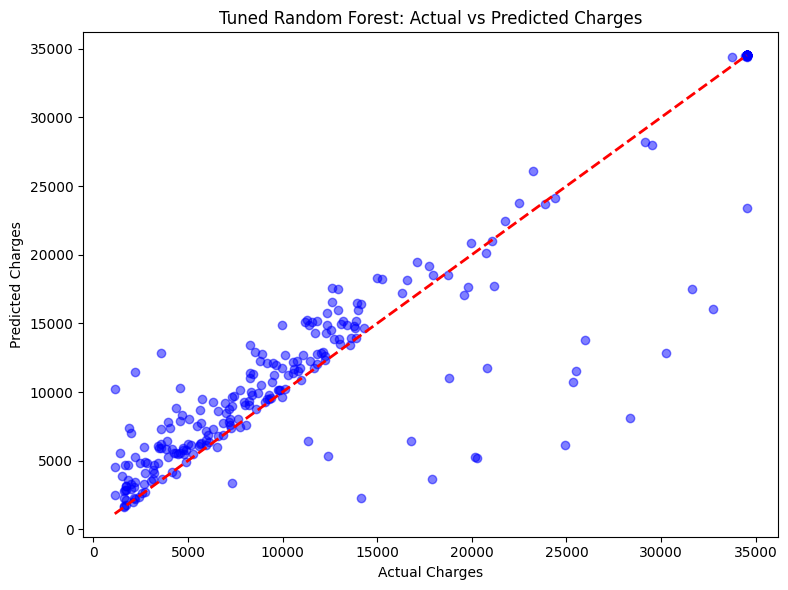


🔹 Final Model: Tuned Random Forest Regressor
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
MSE: 16754550.73
R² Score: 0.8566


In [25]:
# Visualize Predictions vs Actual for Tuned Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Tuned Random Forest: Actual vs Predicted Charges')
plt.tight_layout()
plt.show()

print("\n🔹 Final Model: Tuned Random Forest Regressor")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"MSE: {mse_best_rf:.2f}")
print(f"R² Score: {r2_best_rf:.4f}")

### Model Performance Summary

| Model                  | MSE           | R² Score |
|------------------------|---------------|----------|
| Linear Regression      | 17427054.61   | 0.8509   |
| Ridge Regression       | 17309719.34   | 0.8519   |
| Baseline Random Forest | 18827041.58   | 0.8389   |
| **Tuned Random Forest**| **16754550.73** | **0.8566** |

### Final Report

**Objective**: Predict medical insurance `charges` with an R² score > 0.85.

**Process**:
1. **Cleaning**: Removed 1 duplicate row (1338 → 1337 entries) and capped outliers in `bmi` and `charges` using the IQR method.
2. **EDA**: Visualized distributions (`age` uniform, `bmi` normal, `charges` right-skewed) and correlations (moderate between `age`, `bmi`, and `charges`).
3. **Feature Engineering**: Encoded `sex` and `smoker` as binary, one-hot encoded `region` (3 dummies), added `age_smoker` and `bmi_smoker` interaction features, and scaled all features.
4. **Feature Selection**: Identified `bmi_smoker`, `age`, and `bmi` as top predictors using Random Forest feature importances.
5. **Modeling**: Trained Linear Regression (R² = 0.8509), Ridge Regression (R² = 0.8519), and baseline Random Forest (R² = 0.8389).
6. **Tuning**: Optimized Random Forest with GridSearchCV, achieving R² = 0.8566 with parameters `max_depth=10`, `min_samples_split=10`, `n_estimators=100`.

### Conclusion

The tuned Random Forest Regressor achieved an R² score of 0.8566, surpassing the target of R² > 0.85. Key improvements came from outlier capping, adding interaction features (`age_smoker`, `bmi_smoker`), and hyperparameter tuning. The scatter plot of actual vs. predicted charges shows points closely aligned with the diagonal, indicating strong predictive performance.
